In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
from os import fdopen, remove, walk
import glob
from tempfile import mkstemp
import shutil
from shutil import move, copymode

In [3]:
from datetime import date

In [4]:
DATASET_PATH = "/Users/noopy/covid19_unknown_spread/dataset"

In [5]:
# get oldest file in the dataset folder
import os, heapq
def newst_files_in_tree(rootfolder, count=1, extension=".csv"):
    return heapq.nlargest(count,
        (os.path.join(dirname, filename)
        for dirname, dirnames, filenames in os.walk(rootfolder)
        for filename in filenames
        if filename.endswith(extension)),
        key=lambda fn: os.stat(fn).st_mtime)

In [6]:
newst_csv = newst_files_in_tree(DATASET_PATH)[0]

In [7]:
df_temp = pd.read_csv(newst_csv, encoding="utf-8")
df_temp.sample(15)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
1633,3362,18331,8.26.,타시도,-,확인 중,NaN
672,4323,21247,9.05.,송파구,-,확인 중,NaN
2817,2178,15619,8.17.,성북구,-,성북구 사랑제일교회 관련,퇴원
3752,1243,12545,6.24.,금천구,-,확인 중,퇴원
3016,1979,15137,8.15.,노원구,-,성북구 사랑제일교회 관련,퇴원
3085,1910,15182,8.15.,노원구,-,골드트레인 관련,퇴원
1007,3988,20312,9.01.,중랑구,-,광진구 혜민병원,퇴원
329,4666,22140,9.12.,성북구,-,확인 중,NaN
4487,508,10015,3.31.,관악구,아일랜드,해외 접촉 추정,퇴원
910,4085,20572,9.02.,송파구,-,기타 확진자 접촉,퇴원


In [8]:
# overwrite whatever cell value that contains "확인" as "확인 중"
df_temp.loc[df_temp["접촉력"].str.contains("확인"),"접촉력"] = "확인 중"

# check whether those two arrays are combined
df_temp.loc[df_temp["접촉력"].str.contains("확인"),"접촉력"].unique()

array(['확인 중'], dtype=object)

In [9]:
df_temp["접촉력"] = df_temp["접촉력"].str.replace("관련", "")
df_temp["접촉력"] = df_temp["접촉력"].str.strip()

In [10]:
infection_paths = df_temp["접촉력"].unique()
print(len(infection_paths))
infection_paths

239


array(['확인 중', '강남구 소재 대우디오빌', '해외 접촉 추정', '관악구 소재 사우나', '기타 확진자 접촉',
       '타시도 확진자 접촉', '강남구 통신판매업', '강남구 동훈산업개발', '양천구 양천경찰서', '은평구 수색성당',
       '강남구 K보건산업', '건축설명회', '서대문구 세브란스병원', '서울지방국세청', '수도권 지인모임',
       '서대문구 소재 세브란스병원', '서대문구 세브란스 병원', '성남 서호주간센터', '서대문구 지인모임',
       '영등포 지인모임', '송파구 우리교회', '송파구 교회', '관악구 판매업소', '광진구 혜민병원',
       '8.15서울도심집회', '도봉구 건설현장', '도봉구 운동시설', '송파구 쿠팡', '종로구청',
       '노원구 빛가온교회', '동작구 요양시설', '서초구 장애인교육시설', '강동구 BF모바일',
       '영등포구 일련정종 서울포교소', '동작구 진흥글로벌', '구로구 아파트', 'KT가좌지사', '성북구 사랑제일교회',
       '노원구 기도모임', '관악구 가족모임', '영등포구 국회출입기자', '은평구 헤어콕', '송파구 소재병원',
       '극단 산', '영등포구 권능교회', '강동구 소재 병원', '다래경매', '성북구 체대입시', '성북구 요양시설',
       '중구소재 은행', '중랑구 소재 체육시설', '동작구 소재 서울신학교', '용인시 우리제일교회', '노원구 손해보험',
       '구로구 보성운수', '강서구 서울대효요양병원', '강북구 일가족', '강서구 보안회사', '롯데리아 종사자 모임',
       '강남구 소재 아파트', '제주 게스트하우스', '성북구 벧엘장로교회', '관악구 김혜근의원',
       '동대문구 sk탁구클럽', '동작구 스터디카페', '군인권센터', '여의도 순복음교회', '중구 보험회사(현대해상)',
       '강서구 병원', '종로구 혜화경찰서', '양천구 되

In [11]:
df_date = df_temp.sort_values(["연번"], ascending=False)
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,4995,23042,9.20.,타시도,-,확인 중,NaN
1,4994,23024,9.20.,서초,-,강남구 소재 대우디오빌,NaN
2,4993,23016,9.20.,기타,-,해외 접촉 추정,NaN
3,4992,23027,9.20.,타시도,-,관악구 소재 사우나,NaN
4,4991,23026,9.20.,관악구,-,기타 확진자 접촉,NaN


In [12]:
df_date["확진일"] = df_date["확진일"].str.replace(".", "-")
df_date["확진일"] = df_date["확진일"].str[:-1]
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,4995,23042,9-20,타시도,-,확인 중,NaN
1,4994,23024,9-20,서초,-,강남구 소재 대우디오빌,NaN
2,4993,23016,9-20,기타,-,해외 접촉 추정,NaN
3,4992,23027,9-20,타시도,-,관악구 소재 사우나,NaN
4,4991,23026,9-20,관악구,-,기타 확진자 접촉,NaN


In [13]:
df_date["확진일"] = "2020-0" + df_date["확진일"]
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,4995,23042,2020-09-20,타시도,-,확인 중,NaN
1,4994,23024,2020-09-20,서초,-,강남구 소재 대우디오빌,NaN
2,4993,23016,2020-09-20,기타,-,해외 접촉 추정,NaN
3,4992,23027,2020-09-20,타시도,-,관악구 소재 사우나,NaN
4,4991,23026,2020-09-20,관악구,-,기타 확진자 접촉,NaN


In [14]:
df_date.sample(5)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
4980,15,40,2020-02-19,성동구,-,성동구 아파트,퇴원
3726,1269,12620,2020-06-26,관악구,-,왕성교회,퇴원
4430,565,10358,2020-04-06,성동구,"페루, 미국",해외 접촉 추정,퇴원
1004,3991,20350,2020-08-31,송파구,-,확인 중,NaN
4993,2,5,2020-01-30,중랑구,중국 우한시,해외 접촉,퇴원


In [15]:
df = df_date.copy()
df.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,4995,23042,2020-09-20,타시도,-,확인 중,NaN
1,4994,23024,2020-09-20,서초,-,강남구 소재 대우디오빌,NaN
2,4993,23016,2020-09-20,기타,-,해외 접촉 추정,NaN
3,4992,23027,2020-09-20,타시도,-,관악구 소재 사우나,NaN
4,4991,23026,2020-09-20,관악구,-,기타 확진자 접촉,NaN


In [16]:
df.loc[(df["확진일"].str.len() < 10), '확진일'] = df.loc[(df["확진일"].str.len() < 10), '확진일'].str.replace("-0", "-")
df.loc[(df["확진일"].str.len() < 10), '확진일'] = df.loc[(df["확진일"].str.len() < 10), '확진일'].str.replace("-", "-0")
df.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,4995,23042,2020-09-20,타시도,-,확인 중,NaN
1,4994,23024,2020-09-20,서초,-,강남구 소재 대우디오빌,NaN
2,4993,23016,2020-09-20,기타,-,해외 접촉 추정,NaN
3,4992,23027,2020-09-20,타시도,-,관악구 소재 사우나,NaN
4,4991,23026,2020-09-20,관악구,-,기타 확진자 접촉,NaN


In [17]:
df.sample(15)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
952,4043,19848,2020-08-30,노원구,-,기타 확진자 접촉,퇴원
2080,2915,17466,2020-08-23,서대문구,-,성북구 사랑제일교회,퇴원
608,4387,21337,2020-09-06,성북구,-,확인 중,퇴원
43,4952,22925,2020-09-19,중구,-,강남구 동훈산업개발,NaN
555,4440,21555,2020-09-08,관악구,-,동작구 진흥글로벌,NaN
2930,2065,15508,2020-08-16,강동구,-,골드트레인,퇴원
3153,1842,15258,2020-08-15,도봉구,-,성북구 사랑제일교회,퇴원
3015,1980,15193,2020-08-15,타시도,프랑스,확인 중,퇴원
2459,2536,16549,2020-08-20,중랑구,-,확인 중,퇴원
3179,1816,14984,2020-08-14,서초구,-,용인시 우리제일교회,퇴원


In [18]:
df.to_csv("./dataset_predict/df_wrangle.csv", index=False)

In [19]:
temp = df["확진일"].value_counts().rename_axis('date').reset_index(name='new_confirmed')
temp.head()

,date,new_confirmed
0,2020-08-29,167
1,2020-08-27,160
2,2020-08-26,157
3,2020-08-18,151
4,2020-08-15,146


In [20]:
df_predict = temp.sort_values(by="date")
df_predict.head()

,date,new_confirmed
209,2020-01-24,1
178,2020-01-30,3
177,2020-01-31,3
198,2020-02-02,1
192,2020-02-05,2


### stretch the dataframe as timeseries dataset with interval of 1 day 

In [21]:
df_predict["date"] = pd.to_datetime(df_predict["date"])

In [22]:
df_predict.index = pd.DatetimeIndex(df_predict["date"])
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1
2020-01-30,2020-01-30,3
2020-01-31,2020-01-31,3
2020-02-02,2020-02-02,1
2020-02-05,2020-02-05,2


In [23]:
df_predict = df_predict.resample('D').max()
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,NaT,NaN
2020-01-26,NaT,NaN
2020-01-27,NaT,NaN
2020-01-28,NaT,NaN


In [24]:
df_predict["date"] = df_predict.index
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,2020-01-25,NaN
2020-01-26,2020-01-26,NaN
2020-01-27,2020-01-27,NaN
2020-01-28,2020-01-28,NaN


In [25]:
df_predict = df_predict.fillna(0)
df_predict[:10]

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,2020-01-25,0.0
2020-01-26,2020-01-26,0.0
2020-01-27,2020-01-27,0.0
2020-01-28,2020-01-28,0.0
2020-01-29,2020-01-29,0.0
2020-01-30,2020-01-30,3.0
2020-01-31,2020-01-31,3.0
2020-02-01,2020-02-01,0.0


In [26]:
df_predict.to_csv("dataset_predict/df_predict.csv", index=False)

In [27]:
df_predict =  pd.read_csv("dataset_predict/df_predict.csv", encoding="utf-8")

### get untracked patients information

In [28]:
df_untracked = df[df["접촉력"]=="확인 중"]
df_untracked

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,4995,23042,2020-09-20,타시도,-,확인 중,NaN
13,4982,23014,2020-09-20,성동구,-,확인 중,NaN
14,4981,22991,2020-09-20,금천구,-,확인 중,NaN
15,4980,23001,2020-09-20,영등포구,-,확인 중,NaN
16,4979,23004,2020-09-20,마포구,-,확인 중,NaN
...,...,...,...,...,...,...,...
4939,56,1768,2020-02-25,고양시,-,확인 중,퇴원
4953,42,1370,2020-02-25,노원구,-,확인 중,퇴원
4956,39,924,2020-02-25,평택,-,확인 중,퇴원
4957,38,907,2020-02-25,관악구,-,확인 중,퇴원


In [29]:
df_untracked_temp = df_untracked.groupby(by=["확진일"]).size()
df_untracked_temp = df_untracked_temp.rename_axis('date').reset_index(name='new_untracked')
df_untracked_temp

,date,new_untracked
0,2020-02-25,6
1,2020-02-26,1
2,2020-02-27,2
3,2020-02-28,2
4,2020-03-02,2
...,...,...
135,2020-09-16,25
136,2020-09-17,10
137,2020-09-18,7
138,2020-09-19,11


In [30]:
df_untracked_no = df_untracked_temp

In [31]:
df_merged = pd.merge(df_predict, df_untracked_no, how="left", on="date")
df_merged = df_merged.fillna(0)
df_merged.head(15)

,date,new_confirmed,new_untracked
0,2020-01-24,1.0,0.0
1,2020-01-25,0.0,0.0
2,2020-01-26,0.0,0.0
3,2020-01-27,0.0,0.0
4,2020-01-28,0.0,0.0
5,2020-01-29,0.0,0.0
6,2020-01-30,3.0,0.0
7,2020-01-31,3.0,0.0
8,2020-02-01,0.0,0.0
9,2020-02-02,1.0,0.0


In [32]:
df_merged.tail(15)

,date,new_confirmed,new_untracked
226,2020-09-06,44.0,13.0
227,2020-09-07,76.0,19.0
228,2020-09-08,30.0,10.0
229,2020-09-09,47.0,9.0
230,2020-09-10,64.0,9.0
231,2020-09-11,49.0,13.0
232,2020-09-12,34.0,13.0
233,2020-09-13,41.0,8.0
234,2020-09-14,36.0,10.0
235,2020-09-15,49.0,11.0


In [33]:
list_infection_paths_no = []
for index, row in df_merged.iterrows():
    filter_end_date = row["date"]
    # print(filter_end_date)
    df_filtered = df.loc[df['확진일'] <= filter_end_date]
    
    # 확진자 접촉력이 밝혀진 경우
    infection_paths_known_no = len(df_filtered["접촉력"].unique())
    
    # "기타 확진자 접촉", "타시도 확진자 접촉" 항목 485건 / R0
    etc_contact_no = len(df_filtered[df_filtered["접촉력"].str.contains("기타 확진자 접촉")])/1.5
    state_contact_no = len(df_filtered[df_filtered["접촉력"].str.contains("타시도 확진자 접촉")])/1.5

    infection_paths_no = infection_paths_known_no + etc_contact_no + state_contact_no
    list_infection_paths_no.append(int(infection_paths_no))
print(list_infection_paths_no[:10])
print(list_infection_paths_no[-10:])

[1, 1, 1, 1, 1, 1, 2, 4, 4, 4]
[737, 749, 764, 774, 789, 803, 817, 823, 827, 837]


In [34]:
df_merged["no_paths"] = list_infection_paths_no
df_merged["new_confirmed"] = df_merged["new_confirmed"].apply(int)
df_merged["new_untracked"] = df_merged["new_untracked"].apply(int)
df_merged.head()

,date,new_confirmed,new_untracked,no_paths
0,2020-01-24,1,0,1
1,2020-01-25,0,0,1
2,2020-01-26,0,0,1
3,2020-01-27,0,0,1
4,2020-01-28,0,0,1


In [35]:
df_merged.tail()

,date,new_confirmed,new_untracked,no_paths
236,2020-09-16,62,25,803
237,2020-09-17,43,10,817
238,2020-09-18,40,7,823
239,2020-09-19,28,11,827
240,2020-09-20,23,5,837


In [36]:
df_merged["new_no_paths"] = df_merged["no_paths"].diff()
df_merged.tail(10)

,date,new_confirmed,new_untracked,no_paths,new_no_paths
231,2020-09-11,49,13,737,11.0
232,2020-09-12,34,13,749,12.0
233,2020-09-13,41,8,764,15.0
234,2020-09-14,36,10,774,10.0
235,2020-09-15,49,11,789,15.0
236,2020-09-16,62,25,803,14.0
237,2020-09-17,43,10,817,14.0
238,2020-09-18,40,7,823,6.0
239,2020-09-19,28,11,827,4.0
240,2020-09-20,23,5,837,10.0


In [37]:
df_merged = df_merged[["date", "new_confirmed", "new_untracked", "new_no_paths"]]

In [38]:
df_merged.to_csv("dataset_predict/df_predict.csv", index=False)

### Label holiday as column

In [39]:
import json

list_calendar=[]

calendar_file = "./korean-calendar/korean-calendar.json"
# read file
with open(calendar_file, 'r') as myfile:
    data=myfile.readlines()

data = [x.strip() for x in data] 

for i in data:
    calendar_data = i[43:]
    calendar_item = "{"+calendar_data
    calendar_item_json = json.loads(calendar_item)
    list_calendar.append(calendar_item_json)
list_calendar[:10]

[{'sc': '2000-01-01', 'lc': '1999-11-25', 'w': 7, 'h': True, 'ht': '신정'},
 {'sc': '2000-01-02', 'lc': '1999-11-26', 'w': 1, 'h': False, 'ht': ''},
 {'sc': '2000-01-03', 'lc': '1999-11-27', 'w': 2, 'h': False, 'ht': ''},
 {'sc': '2000-01-04', 'lc': '1999-11-28', 'w': 3, 'h': False, 'ht': ''},
 {'sc': '2000-01-05', 'lc': '1999-11-29', 'w': 4, 'h': False, 'ht': ''},
 {'sc': '2000-01-06', 'lc': '1999-11-30', 'w': 5, 'h': False, 'ht': ''},
 {'sc': '2000-01-07', 'lc': '1999-12-01', 'w': 6, 'h': False, 'ht': ''},
 {'sc': '2000-01-08', 'lc': '1999-12-02', 'w': 7, 'h': False, 'ht': ''},
 {'sc': '2000-01-09', 'lc': '1999-12-03', 'w': 1, 'h': False, 'ht': ''},
 {'sc': '2000-01-10', 'lc': '1999-12-04', 'w': 2, 'h': False, 'ht': ''}]

In [40]:
df_calendar = pd.DataFrame(list_calendar)
df_calendar = df_calendar[["sc", "w", "h"]]
df_calendar.head()

,sc,w,h
0,2000-01-01,7,True
1,2000-01-02,1,False
2,2000-01-03,2,False
3,2000-01-04,3,False
4,2000-01-05,4,False


In [41]:
# notate sunday, friday, saturday as weekend: which is 1
def label_weekend(row):
    # sunday
    if row['w'] == 1:
        return 1
    # friday
    if row['w'] == 6:
        return 1
    # saturday
    if row['w'] == 7:
        return 1
    else:
        return 0

In [42]:
df_calendar["is_weekend"] = df_calendar.apply(lambda row: label_weekend(row), axis=1)
df_calendar.head(10)

,sc,w,h,is_weekend
0,2000-01-01,7,True,1
1,2000-01-02,1,False,1
2,2000-01-03,2,False,0
3,2000-01-04,3,False,0
4,2000-01-05,4,False,0
5,2000-01-06,5,False,0
6,2000-01-07,6,False,1
7,2000-01-08,7,False,1
8,2000-01-09,1,False,1
9,2000-01-10,2,False,0


In [43]:
# rename dataframe name
df_calendar.rename(columns = {'sc':'date', 'h':'is_holiday'}, inplace = True)

In [44]:
# if it is holiday, notate as 1. If not, notate as 0
df_calendar.loc[df_calendar["is_holiday"]==True, "is_holiday"] = 1
df_calendar.loc[df_calendar["is_holiday"]==False, "is_holiday"] = 0
df_calendar[:10]

,date,w,is_holiday,is_weekend
0,2000-01-01,7,1,1
1,2000-01-02,1,0,1
2,2000-01-03,2,0,0
3,2000-01-04,3,0,0
4,2000-01-05,4,0,0
5,2000-01-06,5,0,0
6,2000-01-07,6,0,1
7,2000-01-08,7,0,1
8,2000-01-09,1,0,1
9,2000-01-10,2,0,0


In [45]:
df_calendar.to_csv("dataset_predict/df_calendar.csv", index=False)

In [46]:
df_calendar_subset = df_calendar[["date", "is_holiday", "is_weekend"]]

In [47]:
df_train = pd.merge(df_merged, df_calendar_subset, how="left", on="date")
df_train.tail()

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend
236,2020-09-16,62,25,14.0,0,0
237,2020-09-17,43,10,14.0,0,0
238,2020-09-18,40,7,6.0,0,1
239,2020-09-19,28,11,4.0,0,1
240,2020-09-20,23,5,10.0,0,1


### Add Government Social Distancing Policy

In [48]:
df_train["gov_policy"] = 0
df_train[-10:]

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend,gov_policy
231,2020-09-11,49,13,11.0,0,1,0
232,2020-09-12,34,13,12.0,0,1,0
233,2020-09-13,41,8,15.0,0,1,0
234,2020-09-14,36,10,10.0,0,0,0
235,2020-09-15,49,11,15.0,0,0,0
236,2020-09-16,62,25,14.0,0,0,0
237,2020-09-17,43,10,14.0,0,0,0
238,2020-09-18,40,7,6.0,0,1,0
239,2020-09-19,28,11,4.0,0,1,0
240,2020-09-20,23,5,10.0,0,1,0


In [49]:
# 서울의 사회적 거리두기 2단계는 8월 16일부터 조치됨
# 서울에는 8월 19일 0시 기준으로 새로운 조치들이 추가되며, 흔히 얘기하는 2.5단계가 됨. 이후에 기간 연장을 해서 9.7(월)0시 ~ 9.13(일)24시까지 2.5단계가 시행됨

df_train.loc[(df_train["date"]>="2020-08-16") & (df_train["date"]<="2020-08-18"),"gov_policy"] = 2
df_train.loc[(df_train["date"]>="2020-08-19") & (df_train["date"]<="2020-09-13"),"gov_policy"] = 3


In [50]:
df_train.to_csv("./dataset_predict/df_train.csv", index=False)

## EDA

In [51]:
df_train.corr()

,new_confirmed,new_untracked,new_no_paths,is_weekend,gov_policy
new_confirmed,1.000000,0.874071,0.871402,-0.019979,0.789701
new_untracked,0.874071,1.000000,0.916680,-0.036401,0.800191
new_no_paths,0.871402,0.916680,1.000000,0.010766,0.847755
is_weekend,-0.019979,-0.036401,0.010766,1.000000,0.012376
gov_policy,0.789701,0.800191,0.847755,0.012376,1.000000


<AxesSubplot:>

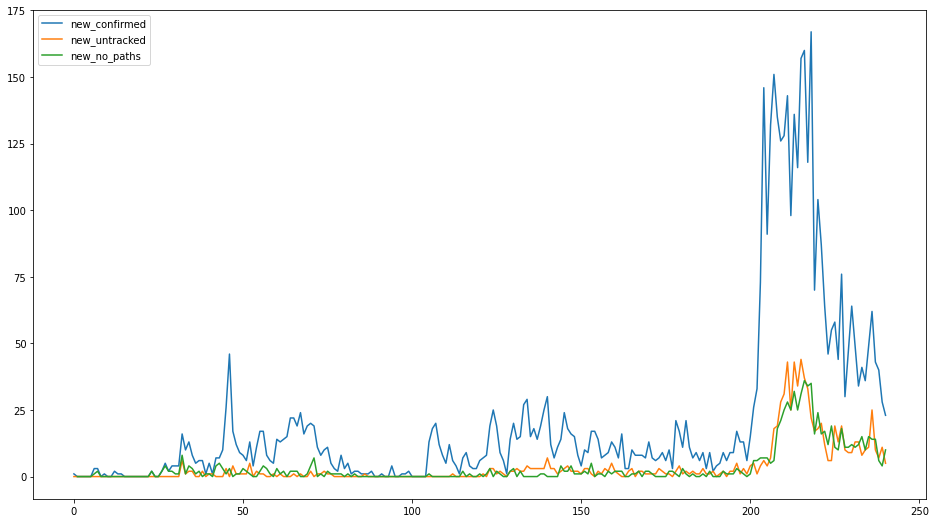

In [52]:
# 전체 그래프
df_train[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

<AxesSubplot:>

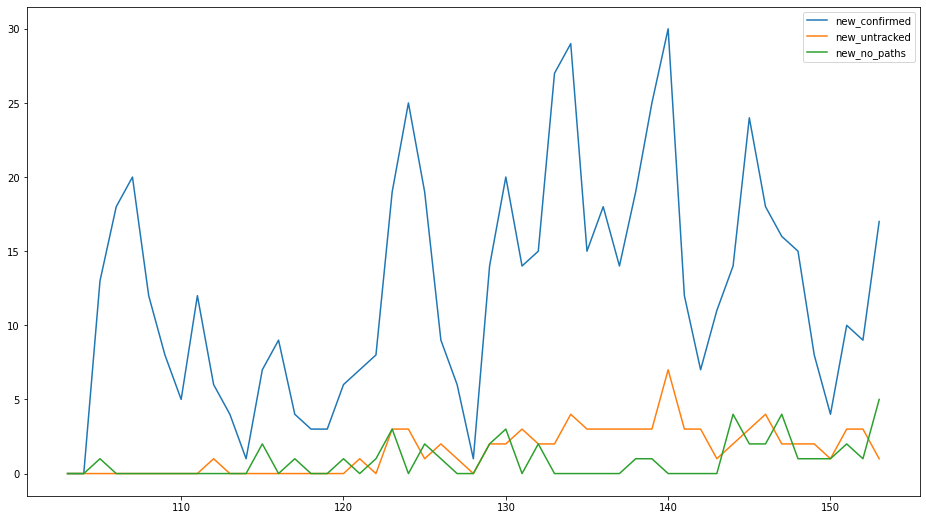

In [53]:
itaewon_crisis = df_train[(df_train["date"]>="2020-05-06") & (df_train["date"]<="2020-06-25")]
itaewon_crisis[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))


<AxesSubplot:>

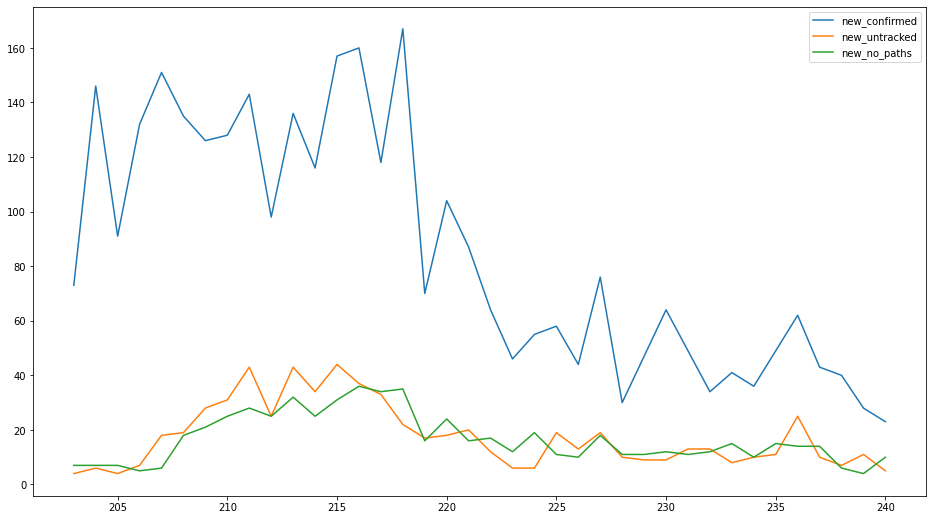

In [54]:
# 서울시 사랑제일교회 광복절 집회 이후의 데이터
jkh_crisis = df_train[(df_train["date"]>="2020-08-14")]
jkh_crisis[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

<AxesSubplot:>

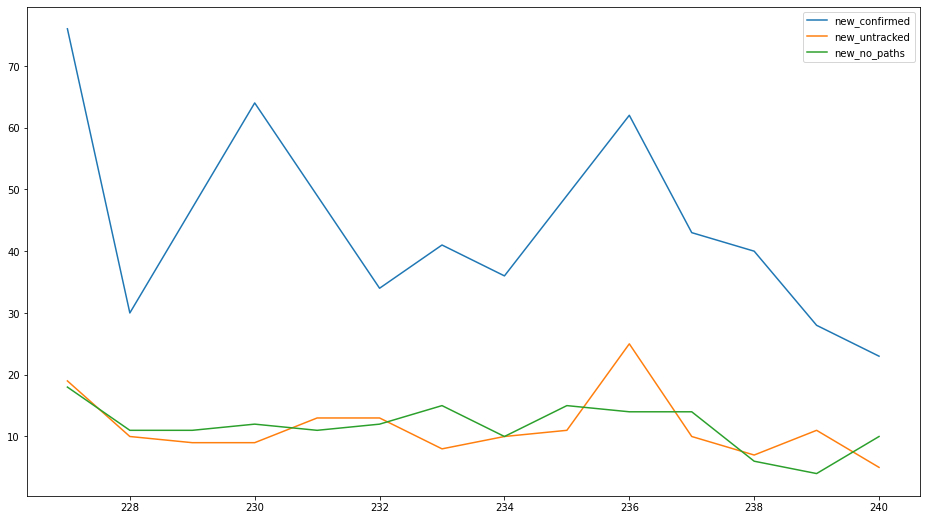

In [55]:
# 최근 2주 데이터
recent_two_weeks_data = df_train.tail(14)
recent_two_weeks_data[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

<AxesSubplot:>

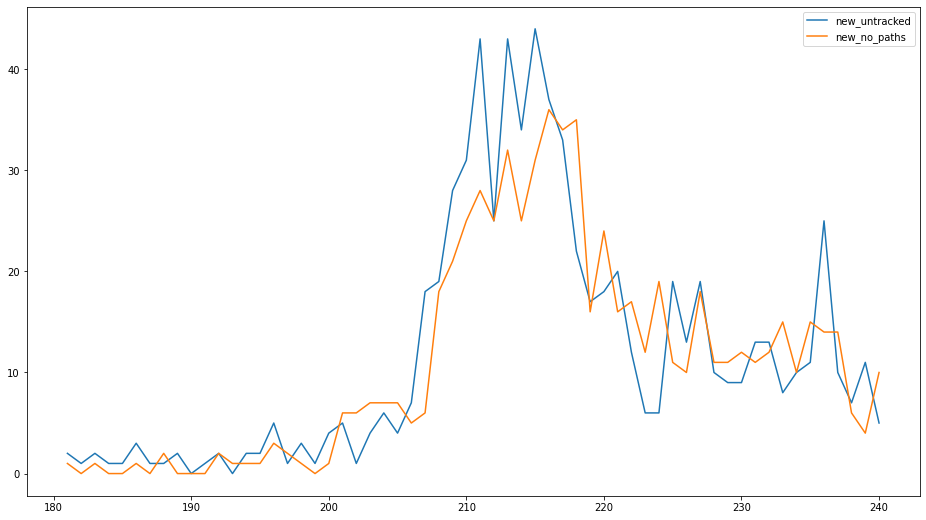

In [56]:
# 확인된 감염경로 개수와 경로 미확인 감염자 트렌드
unknown_and_paths_graph = df_train[["new_untracked", "new_no_paths"]][-60:].plot(figsize=(16,9))
unknown_and_paths_graph

In [57]:
fig = unknown_and_paths_graph.get_figure()
fig.savefig('./img/unknown_and_paths_graph.png')